14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


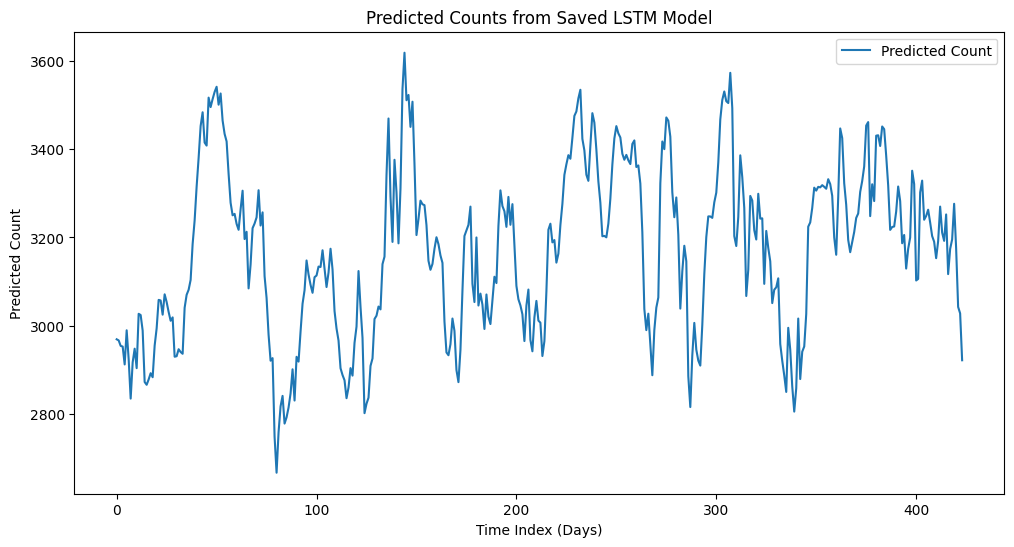

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
         Date  Actual    Predicted
0  2011-01-31    2863  2969.494385
1  2011-02-01    3218  2966.972900
2  2011-02-02    3343  2954.531738
3  2011-02-03    2575  2953.068359
4  2011-02-04    3357  2912.586670
5  2011-02-05    2702  2989.862305
6  2011-02-06    3338  2924.406006
7  2011-02-07    3004  2835.309082
8  2011-02-08    2404  2917.270996
9  2011-02-09    3681  2948.230225
10 2011-02-10    2994  2904.192383
11 2011-02-11    3441  3027.150146
12 2011-02-12    3270  3024.464355
13 2011-02-13    3641  2989.240967
14 2011-02-14    2982  2872.811035
15 2011-02-15    3051  2866.551514
16 2011-02-16    2678  2878.684082
17 2011-02-17    3234  2892.763672
18 2011-02-18    3346  2883.645996
19 2011-02-19    2890  2955.145752
         Date  Actual    Predicted  Absolute_Error
0  2011-01-31    2863  2969.494385      106.494385
1  2011-02-01    3218  2966.972900      251.027100
2  2011-02-02    3343  2954.531738      388.468262
3  2011-02-03    2575

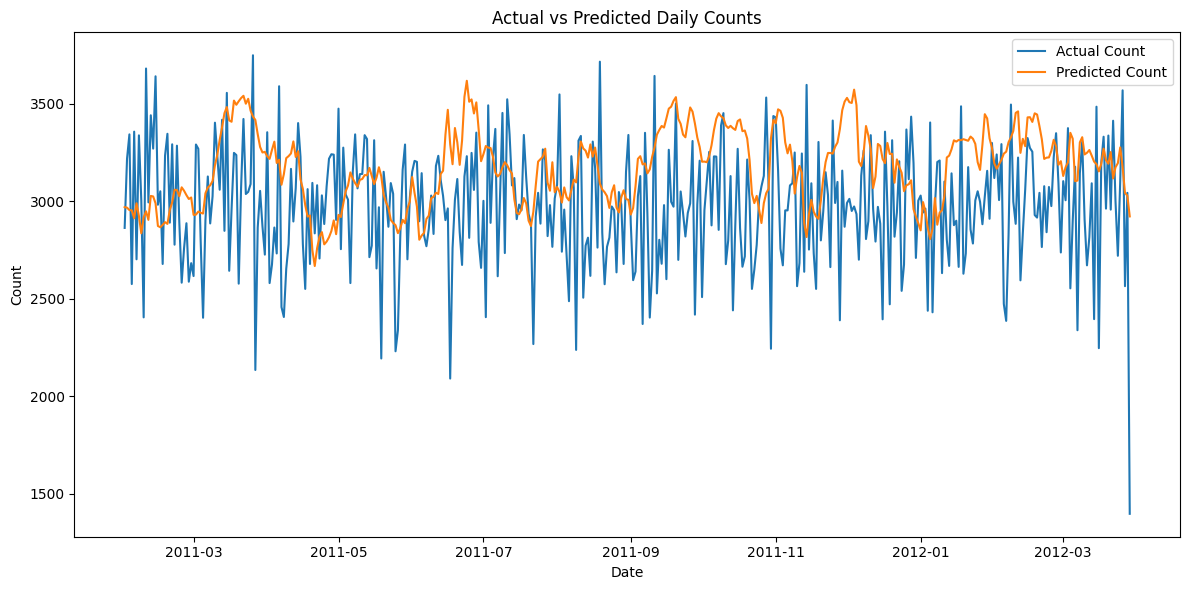

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler




model = load_model('./python/saved_lstm_model.h5')




look_back = 30  





original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)


original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)
features_cols = ['season', 'weather', 'temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos']
original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()


daily_features = original_features.resample('D').mean().loc[original_targets.index]




scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))







new_data = pd.read_csv('./data/ola_updated.csv')
new_data['time'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])
new_data.set_index('time', inplace=True)
new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)
new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
new_features = new_data[features_cols].resample('D').mean()


new_scaled = scaler_X.transform(new_features)




def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(new_scaled, look_back)




y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)




import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_pred)), y_pred, label='Predicted Count')
plt.title('Predicted Counts from Saved LSTM Model')
plt.xlabel('Time Index (Days)')
plt.ylabel('Predicted Count')
plt.legend()
plt.show()
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler




model = load_model('./python/saved_lstm_model.h5')




look_back = 30  





original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)


original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)
features_cols = ['season', 'weather', 'temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos']
original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()


daily_features = original_features.resample('D').mean().loc[original_targets.index]




scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))







new_data = pd.read_csv('./data/ola_updated.csv')
new_data['time'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])
new_data.set_index('time', inplace=True)
new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)
new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
new_features = new_data[features_cols].resample('D').mean()


new_scaled = scaler_X.transform(new_features)




def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(new_scaled, look_back)




y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)




y_actual = original_targets.values[look_back:]
comparison_df = pd.DataFrame({
    'Date': original_targets.index[look_back:],
    'Actual': y_actual,
    'Predicted': y_pred.flatten()
})
print(comparison_df.head(20))
comparison_df['Absolute_Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Absolute_Error'].mean()
print(comparison_df.head(20))
print(f'\nMean Absolute Error: {mae:.2f}')


plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Count')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Count')
plt.title('Actual vs Predicted Daily Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


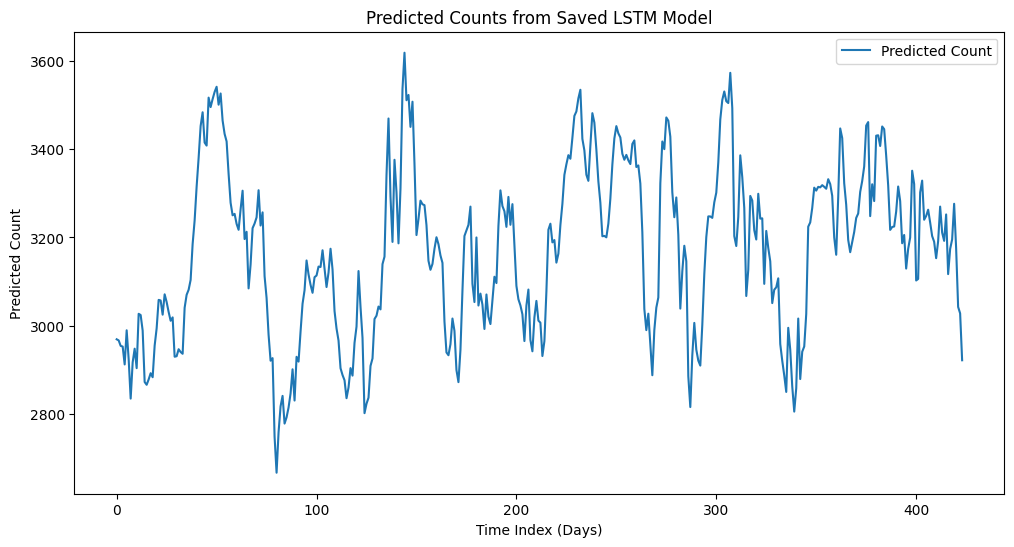

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
         Date  Actual    Predicted
0  2011-01-31    2863  2969.494385
1  2011-02-01    3218  2966.972900
2  2011-02-02    3343  2954.531738
3  2011-02-03    2575  2953.068359
4  2011-02-04    3357  2912.586670
5  2011-02-05    2702  2989.862305
6  2011-02-06    3338  2924.406006
7  2011-02-07    3004  2835.309082
8  2011-02-08    2404  2917.270996
9  2011-02-09    3681  2948.230225
10 2011-02-10    2994  2904.192383
11 2011-02-11    3441  3027.150146
12 2011-02-12    3270  3024.464355
13 2011-02-13    3641  2989.240967
14 2011-02-14    2982  2872.811035
15 2011-02-15    3051  2866.551514
16 2011-02-16    2678  2878.684082
17 2011-02-17    3234  2892.763672
18 2011-02-18    3346  2883.645996
19 2011-02-19    2890  2955.145752
         Date  Actual    Predicted  Absolute_Error
0  2011-01-31    2863  2969.494385      106.494385
1  2011-02-01    3218  2966.972900      251.027100
2  2011-02-02    3343  2954.531738      388.468262
3  2011-02-03    257

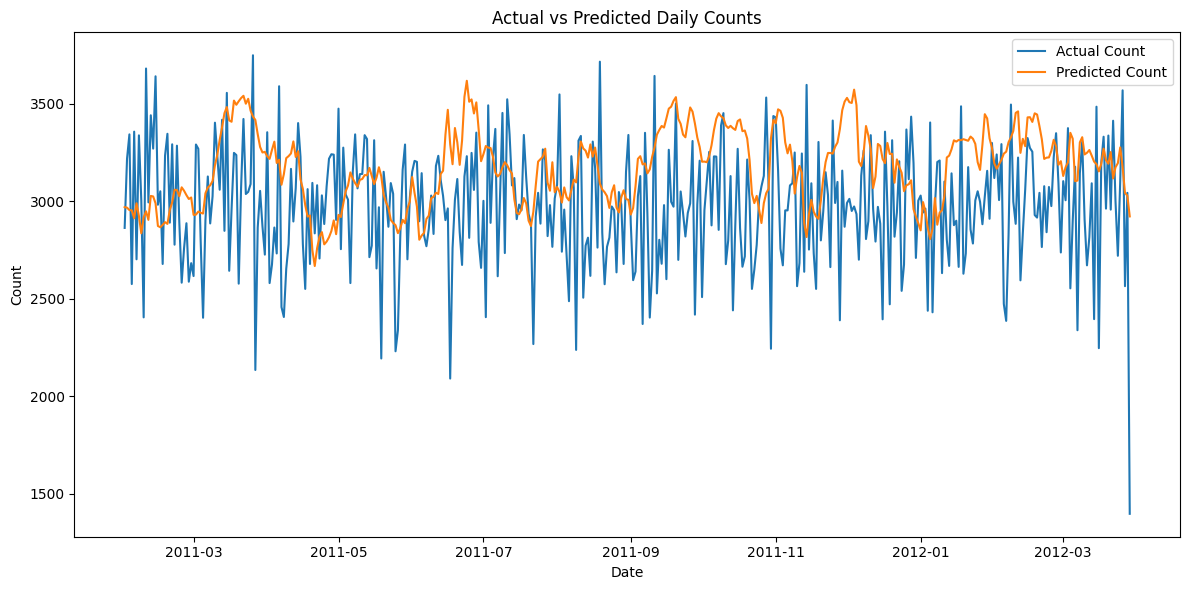

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler




model = load_model('./saved_lstm_model.h5')




look_back = 30  





original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)


original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)
features_cols = ['season', 'weather', 'temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos']
original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()


daily_features = original_features.resample('D').mean().loc[original_targets.index]




scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))







new_data = pd.read_csv('./data/ola_updated.csv')
new_data['time'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])
new_data.set_index('time', inplace=True)
new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)
new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
new_features = new_data[features_cols].resample('D').mean()


new_scaled = scaler_X.transform(new_features)




def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(new_scaled, look_back)




y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)




import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_pred)), y_pred, label='Predicted Count')
plt.title('Predicted Counts from Saved LSTM Model')
plt.xlabel('Time Index (Days)')
plt.ylabel('Predicted Count')
plt.legend()
plt.show()
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler




model = load_model('./saved_lstm_model.h5')




look_back = 30  





original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)


original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)
features_cols = ['season', 'weather', 'temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos']
original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()


daily_features = original_features.resample('D').mean().loc[original_targets.index]




scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))







new_data = pd.read_csv('./data/ola_updated.csv')
new_data['time'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])
new_data.set_index('time', inplace=True)
new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)
new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
new_features = new_data[features_cols].resample('D').mean()


new_scaled = scaler_X.transform(new_features)




def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(new_scaled, look_back)




y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)




y_actual = original_targets.values[look_back:]
comparison_df = pd.DataFrame({
    'Date': original_targets.index[look_back:],
    'Actual': y_actual,
    'Predicted': y_pred.flatten()
})
print(comparison_df.head(20))
comparison_df['Absolute_Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Absolute_Error'].mean()
print(comparison_df.head(20))
print(f'\nMean Absolute Error: {mae:.2f}')


plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Count')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Count')
plt.title('Actual vs Predicted Daily Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()